# PhysMAP: Process Jianing Data

This notebook ports the R analysis from `processJianing.r` to Python using Scanpy and Muon.

**Original R pipeline:**
- Seurat v4 for single-cell analysis
- Multi-modal integration via FindMultiModalNeighbors (WNN)

**Python implementation:**
- Scanpy for single-modality processing
- Muon for multi-modal data handling and integration

## 1. Imports and Configuration

In [454]:
import scanpy as sc
import muon as mu
import numpy as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
from anndata import AnnData
from muon import MuData
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure scanpy
sc.settings.verbosity = 1
sc.settings.set_figure_params(dpi=100, frameon=False, figsize=(6, 5))

In [455]:
# Constants (from constants.R)
RESOLUTION = 2
UMAP_SEED = 42
UMAP_NEIGHBORS = 20
UMAP_MIN_DIST = 0.2
UMAP_METRIC = "cosine"
UMAP_COMPONENTS = 10
N_PCS = 100

## 2. Data Loading

Load the MATLAB data file and create a MuData object with multiple modalities.

In [456]:
def clr_normalize(X):
    """
    Centered Log-Ratio (CLR) normalization per cell (row).
    Equivalent to Seurat's NormalizeData(method='CLR', margin=4).
    
    For each cell, computes: log(x + 1) - mean(log(x + 1))
    This centers the log-transformed data around zero for each cell.
    """
    # Add pseudocount and log transform
    X_pseudo = X + 1
    log_X = np.log(X_pseudo)
    
    # Compute geometric mean per cell (row) and center
    geometric_mean = np.mean(log_X, axis=1, keepdims=True)
    X_clr = log_X - geometric_mean
    
    return X_clr

In [457]:
def extract_matlab_strings(arr):
    """
    Extract strings from MATLAB cell arrays loaded by scipy.io.loadmat.
    MATLAB cell arrays come as nested numpy arrays of objects.
    """
    arr = np.asarray(arr)
    
    # Flatten if needed
    if arr.ndim > 1:
        arr = arr.flatten()
    
    # If it's a single element containing the whole array as string, something is wrong
    # This happens when squeeze_me=True mangles cell arrays
    if len(arr) == 1 and isinstance(arr[0], str) and '[' in arr[0]:
        # This is a string representation of the array, not the actual array
        raise ValueError("MATLAB cell array was converted to string representation. Reload with squeeze_me=False")
    
    result = []
    for item in arr:
        if isinstance(item, np.ndarray):
            # Nested array - extract the string
            if item.size > 0:
                val = item.flat[0]
                result.append(str(val).strip())
            else:
                result.append('')
        elif isinstance(item, str):
            result.append(item.strip())
        else:
            result.append(str(item).strip())
    
    return np.array(result)


def load_rda_file(filepath):
    """
    Load an R .Rda file and return the first object as a numpy array.
    """
    try:
        import pyreadr
        result = pyreadr.read_r(filepath)
        # Get the first (and usually only) object
        key = list(result.keys())[0]
        return result[key].values.flatten()
    except ImportError:
        print(f"Warning: pyreadr not installed. Cannot load {filepath}")
        print("Install with: pip install pyreadr")
        return None
    except Exception as e:
        print(f"Warning: Could not load {filepath}: {e}")
        return None


def load_jianing_data(mat_file_path):
    """
    Load the Jianing mouse S1 dataset from MATLAB file.
    
    Creates a MuData object with the following modalities:
    - ISI: Inter-spike interval data (100 features)
    - WF: Waveform data (351 features)  
    - PSTH: Peri-stimulus time histogram (151 features)
    - features: Hand-crafted features (7 features)
    
    Returns:
        mdata: MuData object with all modalities
        metadata_df: DataFrame with cell metadata
    """
    import os
    
    # Load MATLAB file - use squeeze_me=False to preserve array structure
    mat_data = loadmat(mat_file_path, squeeze_me=False, struct_as_record=False)
    
    # Extract dimensions
    depth_arr = np.asarray(mat_data['depth']).flatten()
    n_cells = len(depth_arr)
    cell_ids = [f"cell_{i}" for i in range(n_cells)]
    
    # Extract continuous variables
    depth = depth_arr.astype(np.float64)
    
    latency = np.asarray(mat_data['latency']).flatten().astype(np.float64)
    latency = np.nan_to_num(latency, nan=0.0)
    
    onset_rate = np.asarray(mat_data['onset_rate']).flatten().astype(np.float64)
    onset_rate = np.nan_to_num(onset_rate, nan=0.0)
    
    # Extract categorical variables (MATLAB cell arrays need special handling)
    layer = extract_matlab_strings(mat_data['layer'])
    cell_type = extract_matlab_strings(mat_data['true_cell_type'])
    
    # Create layerCellType (combined label)
    layer_cell_type = np.array([f"{ct}-{l}" for ct, l in zip(cell_type, layer)])
    
    # Extract feature matrices
    ISI = np.asarray(mat_data['ISI']).astype(np.float64)
    WF = np.asarray(mat_data['waveformV']).astype(np.float64)
    PSTH = np.asarray(mat_data['AllResp']).astype(np.float64)
    
    # Ensure correct orientation (cells x features)
    if ISI.shape[0] != n_cells:
        ISI = ISI.T
    if WF.shape[0] != n_cells:
        WF = WF.T
    if PSTH.shape[0] != n_cells:
        PSTH = PSTH.T
    
    # Extract additional features from 'features' matrix
    features_mat = np.asarray(mat_data['features']).astype(np.float64)
    if features_mat.shape[0] != n_cells:
        features_mat = features_mat.T
    features_mat = np.nan_to_num(features_mat, nan=0.0)
    
    # Load width and ratio_p2t from .Rda files (like the R code does)
    base_dir = os.path.dirname(mat_file_path)
    
    width_path = os.path.join(base_dir, 'width.Rda')
    width = load_rda_file(width_path)
    if width is None:
        print("Warning: Could not load width.Rda, using zeros")
        width = np.zeros(n_cells)
    else:
        width = width.astype(np.float64)
        print(f"Loaded width from .Rda: min={width.min():.4f}, max={width.max():.4f}")
        
    ratio_p2t_path = os.path.join(base_dir, 'ratio_p2t.Rda')
    ratio_p2t = load_rda_file(ratio_p2t_path)
    if ratio_p2t is None:
        print("Warning: Could not load ratio_p2t.Rda, using zeros")
        ratio_p2t = np.zeros(n_cells)
    else:
        ratio_p2t = ratio_p2t.astype(np.float64)
        print(f"Loaded ratio_p2t from .Rda: min={ratio_p2t.min():.4f}, max={ratio_p2t.max():.4f}")
    
    # Create metadata DataFrame
    metadata_df = pd.DataFrame({
        'Layer': layer,
        'CellType': cell_type,
        'layerCellType': layer_cell_type,
        'Depth': depth,
        'latency': latency,
        'onset': onset_rate,
        'width': width,
        'ratio_p2t': ratio_p2t
    }, index=cell_ids)
    
    # Create AnnData objects for each modality
    adata_isi = AnnData(
        X=ISI.astype(np.float32),
        obs=metadata_df.copy()
    )
    adata_isi.var_names = [f"ISI_{i}" for i in range(ISI.shape[1])]
    
    adata_wf = AnnData(
        X=WF.astype(np.float32),
        obs=metadata_df.copy()
    )
    adata_wf.var_names = [f"WF_{i}" for i in range(WF.shape[1])]
    
    adata_psth = AnnData(
        X=PSTH.astype(np.float32),
        obs=metadata_df.copy()
    )
    adata_psth.var_names = [f"PSTH_{i}" for i in range(PSTH.shape[1])]
    
    # Create features AnnData (hand-crafted features)
    feature_names = ['Depth', 'OnsetRate', 'Latency', 'StimFR', 'StimFF']
    if features_mat.shape[1] >= 7:
        feature_names.extend(['width', 'ratio_p2t'])
    else:
        # Add width and ratio_p2t to features matrix
        features_mat = np.column_stack([features_mat, width, ratio_p2t])
        feature_names.extend(['width', 'ratio_p2t'])
    
    adata_features = AnnData(
        X=features_mat.astype(np.float32),
        obs=metadata_df.copy()
    )
    adata_features.var_names = feature_names[:features_mat.shape[1]]
    
    # Create concatenated modality (WF + ISI + PSTH)
    concat_data = np.concatenate([WF, ISI, PSTH], axis=1)
    adata_concat = AnnData(
        X=concat_data.astype(np.float32),
        obs=metadata_df.copy()
    )
    concat_var_names = ([f"WF_{i}" for i in range(WF.shape[1])] + 
                        [f"ISI_{i}" for i in range(ISI.shape[1])] + 
                        [f"PSTH_{i}" for i in range(PSTH.shape[1])])
    adata_concat.var_names = concat_var_names
    
    # Create MuData object
    mdata = MuData({
        'ISI': adata_isi,
        'WF': adata_wf,
        'PSTH': adata_psth,
        'features': adata_features,
        'concat': adata_concat
    })
    
    print(f"\nLoaded {n_cells} cells")
    print(f"Modalities:")
    print(f"  - ISI: {adata_isi.shape}")
    print(f"  - WF: {adata_wf.shape}")
    print(f"  - PSTH: {adata_psth.shape}")
    print(f"  - features: {adata_features.shape}")
    print(f"  - concat: {adata_concat.shape}")
    print(f"\nCell types: {np.unique(cell_type)}")
    print(f"Layers: {np.unique(layer)}")
    
    return mdata, metadata_df

In [458]:
# Load the data
mat_file = "JianingData/MergedData.mat"
mdata, metadata_df = load_jianing_data(mat_file)

Loaded width from .Rda: min=nan, max=nan
Loaded ratio_p2t from .Rda: min=nan, max=nan

Loaded 246 cells
Modalities:
  - ISI: (246, 100)
  - WF: (246, 351)
  - PSTH: (246, 151)
  - features: (246, 7)
  - concat: (246, 602)

Cell types: ['E' 'FS' 'SOM' 'VIP']
Layers: ['23' '4' '5' 'nan']


In [459]:
# Inspect the MuData structure
print(mdata)

MuData object with n_obs × n_vars = 246 × 1211
  5 modalities
    ISI:	246 x 100
      obs:	'Layer', 'CellType', 'layerCellType', 'Depth', 'latency', 'onset', 'width', 'ratio_p2t'
    WF:	246 x 351
      obs:	'Layer', 'CellType', 'layerCellType', 'Depth', 'latency', 'onset', 'width', 'ratio_p2t'
    PSTH:	246 x 151
      obs:	'Layer', 'CellType', 'layerCellType', 'Depth', 'latency', 'onset', 'width', 'ratio_p2t'
    features:	246 x 7
      obs:	'Layer', 'CellType', 'layerCellType', 'Depth', 'latency', 'onset', 'width', 'ratio_p2t'
    concat:	246 x 602
      obs:	'Layer', 'CellType', 'layerCellType', 'Depth', 'latency', 'onset', 'width', 'ratio_p2t'


## 3. Single-Modality Processing

Define a function to process each modality individually, equivalent to `calcRepresentation()` in the R code.

In [460]:
def process_modality(adata, modality_name, n_pcs=30, normalize=True, 
                     n_neighbors=20, metric='cosine', random_state=42):
    """
    Process a single modality through the full Seurat-equivalent pipeline.
    
    Steps:
    1. CLR normalization (optional)
    2. Find variable features (using all features for electrophysiology data)
    3. Scale data (z-score normalization)
    4. PCA
    5. Find neighbors
    6. UMAP (2D)
    7. Leiden clustering
    
    Args:
        adata: AnnData object
        modality_name: Name of the modality (for storing results)
        n_pcs: Number of principal components
        normalize: Whether to apply CLR normalization
        n_neighbors: Number of neighbors for kNN graph
        metric: Distance metric for neighbors
        random_state: Random seed for reproducibility
        
    Returns:
        adata: Processed AnnData object with embeddings and clusters
    """
    adata = adata.copy()
    
    # Store raw data
    adata.layers['raw'] = adata.X.copy()
    
    # 1. CLR normalization (if requested)
    if normalize:
        adata.X = clr_normalize(adata.X)
        adata.layers['normalized'] = adata.X.copy()
    
    # 2. For electrophysiology data, use all features as variable
    # (unlike scRNA-seq where we select highly variable genes)
    adata.var['highly_variable'] = True
    
    # 3. Scale data (z-score normalization)
    sc.pp.scale(adata, max_value=None)
    
    # 4. PCA
    n_pcs_actual = min(n_pcs, min(adata.n_obs, adata.n_vars) - 1)
    sc.tl.pca(adata, n_comps=n_pcs_actual, svd_solver='arpack', random_state=random_state)
    
    # 5. Find neighbors
    sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs_actual, 
                    metric=metric, random_state=random_state)
    
    # 6. UMAP
    sc.tl.umap(adata, random_state=random_state, min_dist=UMAP_MIN_DIST)
    
    # 7. Leiden clustering
    sc.tl.leiden(adata, resolution=RESOLUTION, random_state=random_state)
    
    # Rename clustering column for this modality
    adata.obs[f'{modality_name}_leiden'] = adata.obs['leiden']
    
    print(f"Processed {modality_name}:")
    print(f"  - PCA components: {n_pcs_actual}")
    print(f"  - Clusters found: {adata.obs['leiden'].nunique()}")
    
    return adata

## 4. Process Each Modality

In [461]:
# Process ISI modality (with CLR normalization)
adata_isi = process_modality(
    mdata['ISI'], 
    'ISI', 
    n_pcs=N_PCS, 
    normalize=True,
    metric=UMAP_METRIC
)

Processed ISI:
  - PCA components: 99
  - Clusters found: 9


In [462]:
# Process WF modality (without normalization, per R code)
adata_wf = process_modality(
    mdata['WF'], 
    'WF', 
    n_pcs=N_PCS, 
    normalize=False,  # WF is not normalized in the R code
    metric=UMAP_METRIC
)

Processed WF:
  - PCA components: 100
  - Clusters found: 10


In [463]:
# Process PSTH modality (with CLR normalization)
adata_psth = process_modality(
    mdata['PSTH'], 
    'PSTH', 
    n_pcs=N_PCS, 
    normalize=True,
    metric=UMAP_METRIC
)

Processed PSTH:
  - PCA components: 100
  - Clusters found: 13


In [464]:
# Process concatenated modality (with CLR normalization)
# adata_concat = process_modality(
#     mdata['concat'],
#     'concat',
#     n_pcs=N_PCS,
#     normalize=True,
#     metric=UMAP_METRIC
# )

## 5. Individual Modality Visualizations

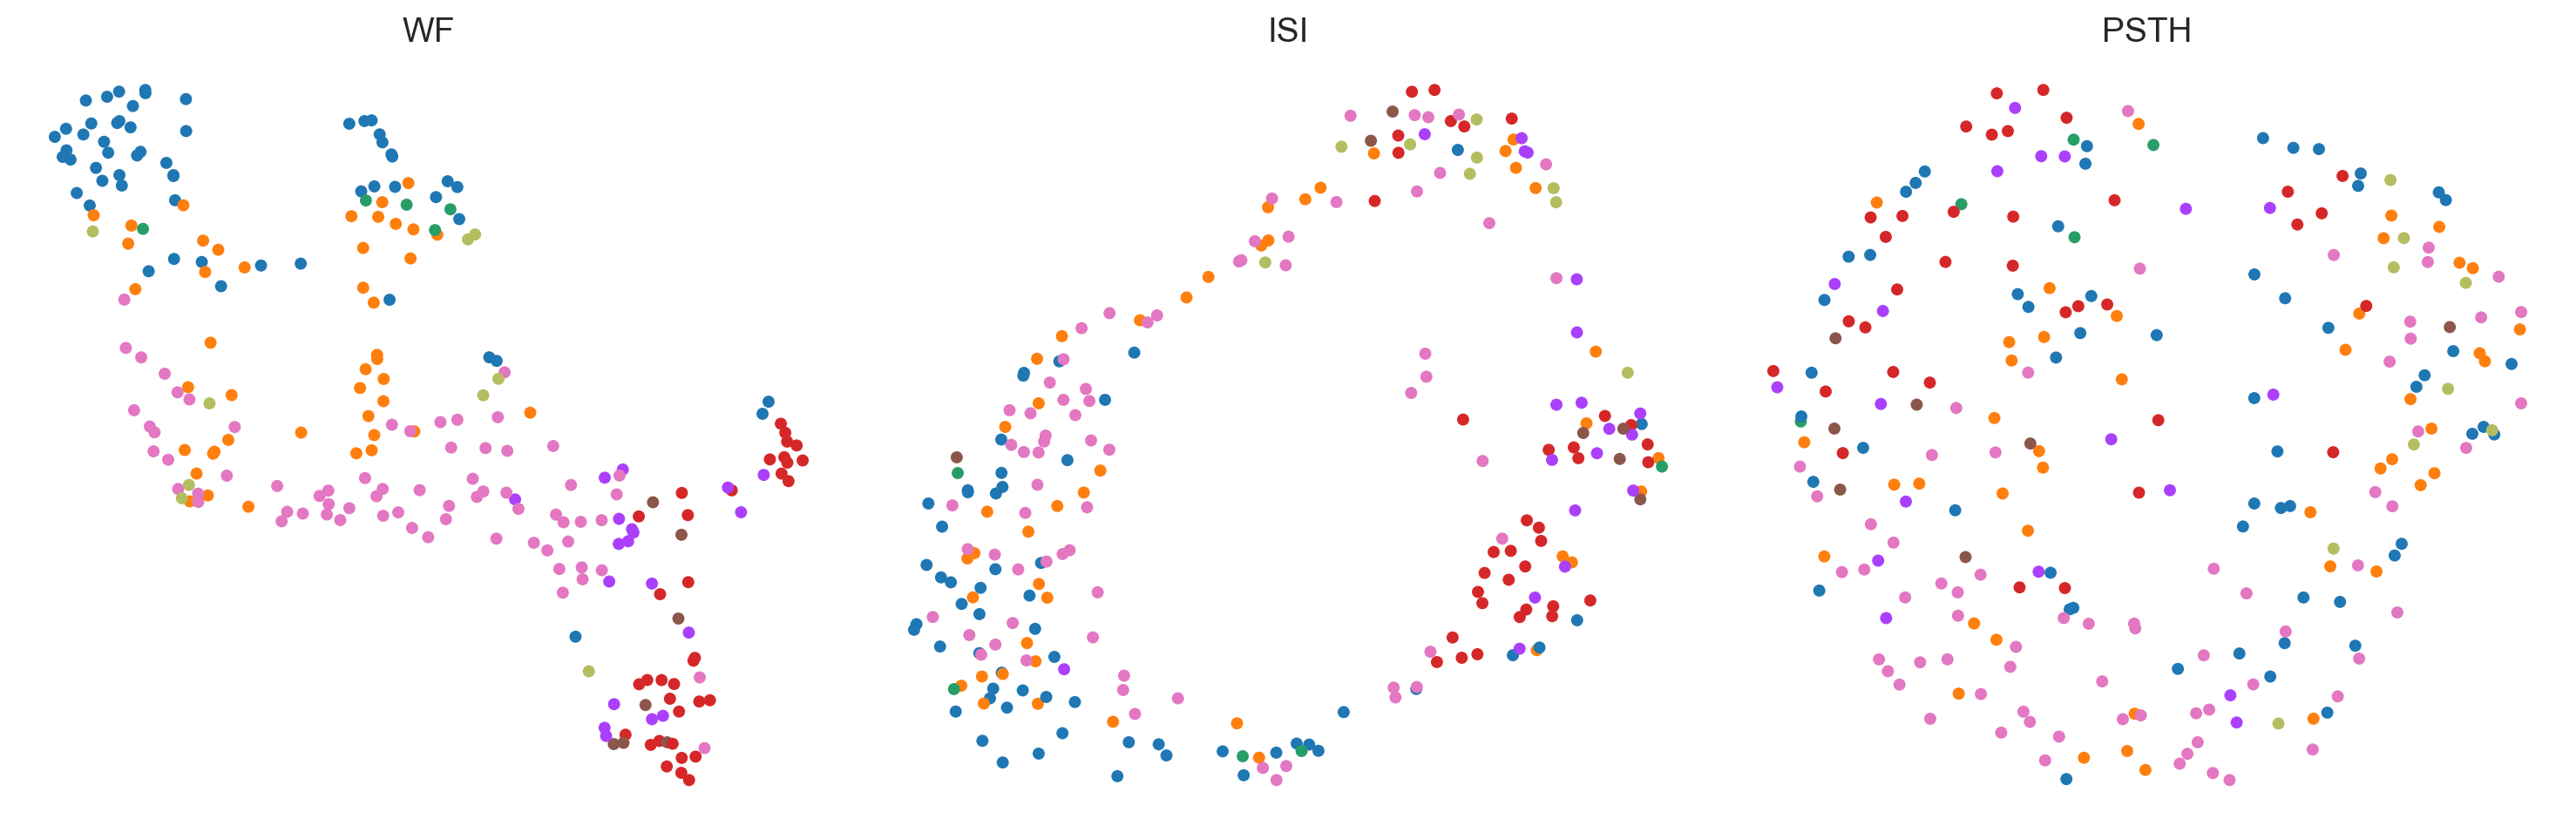

In [465]:
# Create UMAP plots for each modality colored by layerCellType
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

modalities = [
    (adata_wf, 'WF'),
    (adata_isi, 'ISI'),
    (adata_psth, 'PSTH'),
]

for ax, (adata, name) in zip(axes, modalities):
    sc.pl.umap(adata, color='layerCellType', ax=ax, show=False, 
               title=name, legend_loc='none', frameon=False, size=100)

plt.tight_layout()
plt.show()

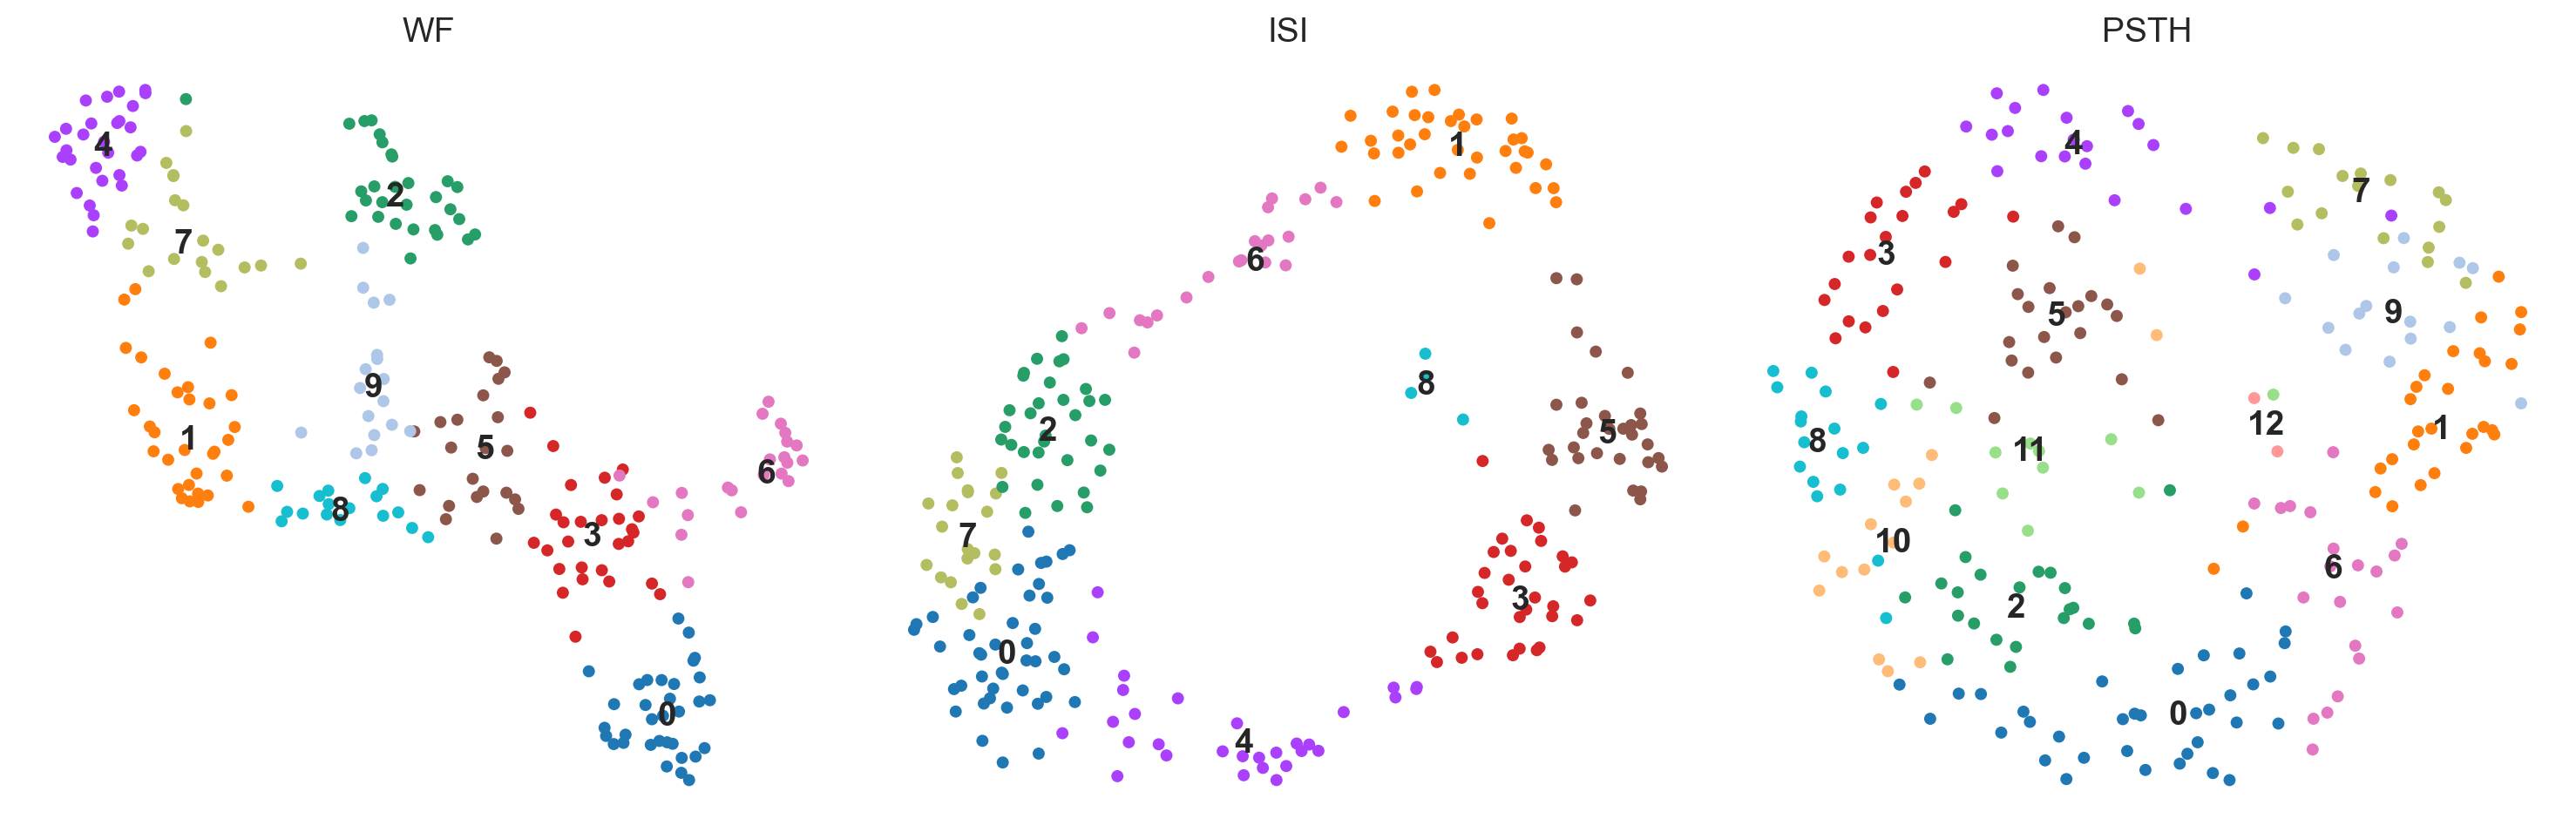

In [466]:
# Create UMAP plots colored by cluster ID for each modality
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

modalities_for_clustering = [
    (adata_wf, 'WF', 'WF_leiden'),
    (adata_isi, 'ISI', 'ISI_leiden'),
    (adata_psth, 'PSTH', 'PSTH_leiden')
]

for ax, (adata, name, cluster_key) in zip(axes, modalities_for_clustering):
    sc.pl.umap(adata, color=cluster_key, ax=ax, show=False,
               title=name, legend_loc='on data', frameon=False,size=100)

plt.tight_layout()
plt.show()

## 6. Multi-Modal Integration

Integrate the three modalities (WF, ISI, PSTH) using a weighted nearest neighbors approach similar to Seurat's FindMultiModalNeighbors.

In [467]:
# Update the MuData object with processed modalities
mdata.mod['ISI'] = adata_isi
mdata.mod['WF'] = adata_wf
mdata.mod['PSTH'] = adata_psth
# mdata.mod['concat'] = adata_concat

# Update the MuData object
mdata.update()

In [468]:
# Muon's multi-modal weighted nearest neighbors integration
# This computes cell-specific weights for each modality based on how well
# each modality captures the local neighborhood structure

# First, ensure each modality has its PCA stored with a unique key
# We need to copy the PCA embeddings to the MuData level
for mod_name in ['WF', 'ISI', 'PSTH']:
    mod = mdata.mod[mod_name]
    # Store PCA in obsm with modality-specific key
    key = f'X_pca_{mod_name}'
    mdata.obsm[key] = mod.obsm['X_pca'][:, :N_PCS]
    print(f"Stored {key}: {mdata.obsm[key].shape}")

print(f"\nAvailable representations in mdata.obsm: {list(mdata.obsm.keys())}")

Stored X_pca_WF: (246, 100)
Stored X_pca_ISI: (246, 99)
Stored X_pca_PSTH: (246, 100)

Available representations in mdata.obsm: ['ISI', 'WF', 'PSTH', 'features', 'concat', 'X_pca_WF', 'X_pca_ISI', 'X_pca_PSTH']


In [469]:
# Compute multi-modal weighted nearest neighbors using Muon
# This is similar to Seurat's FindMultiModalNeighbors
# We only integrate WF, ISI, and PSTH (not features or concat)

print("Computing multi-modal weighted nearest neighbors...")

# Create a subset MuData with only the modalities we want to integrate
mdata_wnn = MuData({
    'WF': mdata.mod['WF'],
    'ISI': mdata.mod['ISI'],
    'PSTH': mdata.mod['PSTH']
})

# Run Muon's WNN on the subset
mu.pp.neighbors(
    mdata_wnn,
    key_added='wnn',
    n_neighbors=UMAP_NEIGHBORS,
    n_bandwidth_neighbors=20,
    n_multineighbors=200,
    metric='euclidean',
    low_memory=False
)

print("WNN graph computed successfully!")

Computing multi-modal weighted nearest neighbors...
WNN graph computed successfully!


In [470]:
# Compute UMAP on the WNN graph
mu.tl.umap(mdata_wnn, neighbors_key='wnn', random_state=UMAP_SEED, min_dist=UMAP_MIN_DIST)

# Copy the WNN UMAP back to the main mdata object
mdata.obsm['X_wnn_umap'] = mdata_wnn.obsm['X_umap'].copy()

print(f"WNN UMAP computed: {mdata.obsm['X_wnn_umap'].shape}")

# Check if modality weights were computed
weight_keys = [k for k in mdata_wnn.obs.columns if 'weight' in k.lower()]
if weight_keys:
    print(f"\nModality weights available: {weight_keys}")
    # Copy weights to main mdata
    for key in weight_keys:
        mdata.obs[key] = mdata_wnn.obs[key].values

WNN UMAP computed: (246, 2)

Modality weights available: ['WF:mod_weight', 'ISI:mod_weight', 'PSTH:mod_weight']


## 7. Final Clustering on Integrated Data

In [471]:
# Run Leiden clustering on the WNN neighbor graph
# The WNN graph is stored at the MuData level in obsp, so we use scanpy directly

# First, let's see what's available
print("Available in mdata_wnn.obsp:", list(mdata_wnn.obsp.keys()))
print("Available in mdata_wnn.uns:", list(mdata_wnn.uns.keys()))

# The WNN connectivities should be in obsp with a key like 'wnn_connectivities'
# We need to run leiden using scanpy on an AnnData that has the WNN graph

# Create a temporary AnnData to run leiden on
import anndata
adata_for_clustering = anndata.AnnData(
    X=np.zeros((mdata_wnn.n_obs, 1)),  # Dummy X matrix
    obs=mdata_wnn.obs.copy()
)

# Copy the WNN graph to the temporary AnnData
connectivities_key = 'wnn_connectivities' if 'wnn_connectivities' in mdata_wnn.obsp else 'connectivities'
distances_key = 'wnn_distances' if 'wnn_distances' in mdata_wnn.obsp else 'distances'

adata_for_clustering.obsp['connectivities'] = mdata_wnn.obsp[connectivities_key]
if distances_key in mdata_wnn.obsp:
    adata_for_clustering.obsp['distances'] = mdata_wnn.obsp[distances_key]

# Add the neighbors info to uns
adata_for_clustering.uns['neighbors'] = {
    'connectivities_key': 'connectivities',
    'distances_key': 'distances',
    'params': {'n_neighbors': UMAP_NEIGHBORS, 'method': 'wnn'}
}

# Run Leiden clustering
sc.tl.leiden(adata_for_clustering, resolution=RESOLUTION, random_state=UMAP_SEED)

# Copy the clustering results back to main mdata
mdata.obs['wnn_leiden'] = adata_for_clustering.obs['leiden'].values
mdata_wnn.obs['leiden'] = adata_for_clustering.obs['leiden'].values

print(f"Found {mdata.obs['wnn_leiden'].nunique()} clusters at resolution {RESOLUTION}")

Available in mdata_wnn.obsp: ['wnn_distances', 'wnn_connectivities']
Available in mdata_wnn.uns: ['wnn', 'umap']
Found 10 clusters at resolution 2


## 8. Final Visualizations

In [472]:
# Prepare data for plotting
# Get UMAP coordinates
umap_df = pd.DataFrame(
    mdata.obsm['X_wnn_umap'],
    columns=['UMAP1', 'UMAP2'],
    index=mdata.obs_names
)

# Get metadata from one of the modalities (they all have the same metadata)
mod_obs = mdata.mod['WF'].obs

umap_df['layerCellType'] = mod_obs['layerCellType'].values
umap_df['CellType'] = mod_obs['CellType'].values
umap_df['cluster'] = mdata.obs['wnn_leiden'].values

# Copy additional metadata
for col in ['Depth', 'latency', 'onset', 'width', 'ratio_p2t']:
    if col in mod_obs.columns:
        umap_df[col] = mod_obs[col].values

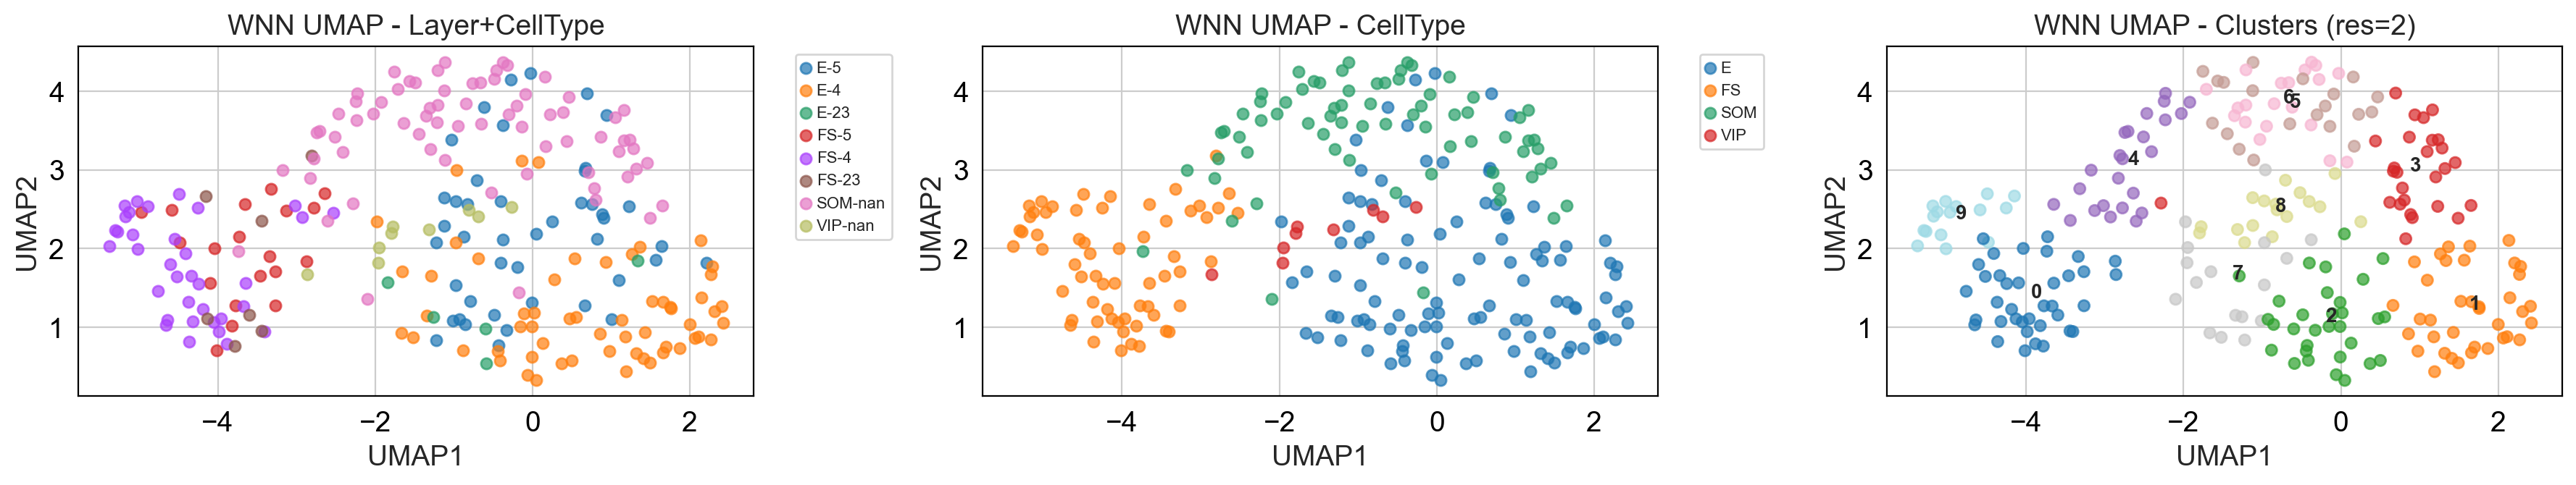

In [491]:
# Create combined visualization (similar to pComb in R)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: WNN UMAP colored by layerCellType
ax = axes[0]
for label in umap_df['layerCellType'].unique():
    mask = umap_df['layerCellType'] == label
    ax.scatter(umap_df.loc[mask, 'UMAP1'], umap_df.loc[mask, 'UMAP2'],
               label=label, s=30, alpha=0.7)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('WNN UMAP - Layer+CellType')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax.set_aspect('equal')

# Plot 2: WNN UMAP colored by CellType
ax = axes[1]
for label in umap_df['CellType'].unique():
    mask = umap_df['CellType'] == label
    ax.scatter(umap_df.loc[mask, 'UMAP1'], umap_df.loc[mask, 'UMAP2'],
               label=label, s=30, alpha=0.7)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('WNN UMAP - CellType')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax.set_aspect('equal')

# Plot 3: WNN UMAP colored by cluster
ax = axes[2]
scatter = ax.scatter(umap_df['UMAP1'], umap_df['UMAP2'],
                     c=umap_df['cluster'].astype(int), cmap='tab20', s=30, alpha=0.7)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title(f'WNN UMAP - Clusters (res={RESOLUTION})')
ax.set_aspect('equal')

# Add cluster labels at centroids
for cluster in umap_df['cluster'].unique():
    mask = umap_df['cluster'] == cluster
    centroid_x = umap_df.loc[mask, 'UMAP1'].mean()
    centroid_y = umap_df.loc[mask, 'UMAP2'].mean()
    ax.annotate(str(cluster), (centroid_x, centroid_y), fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

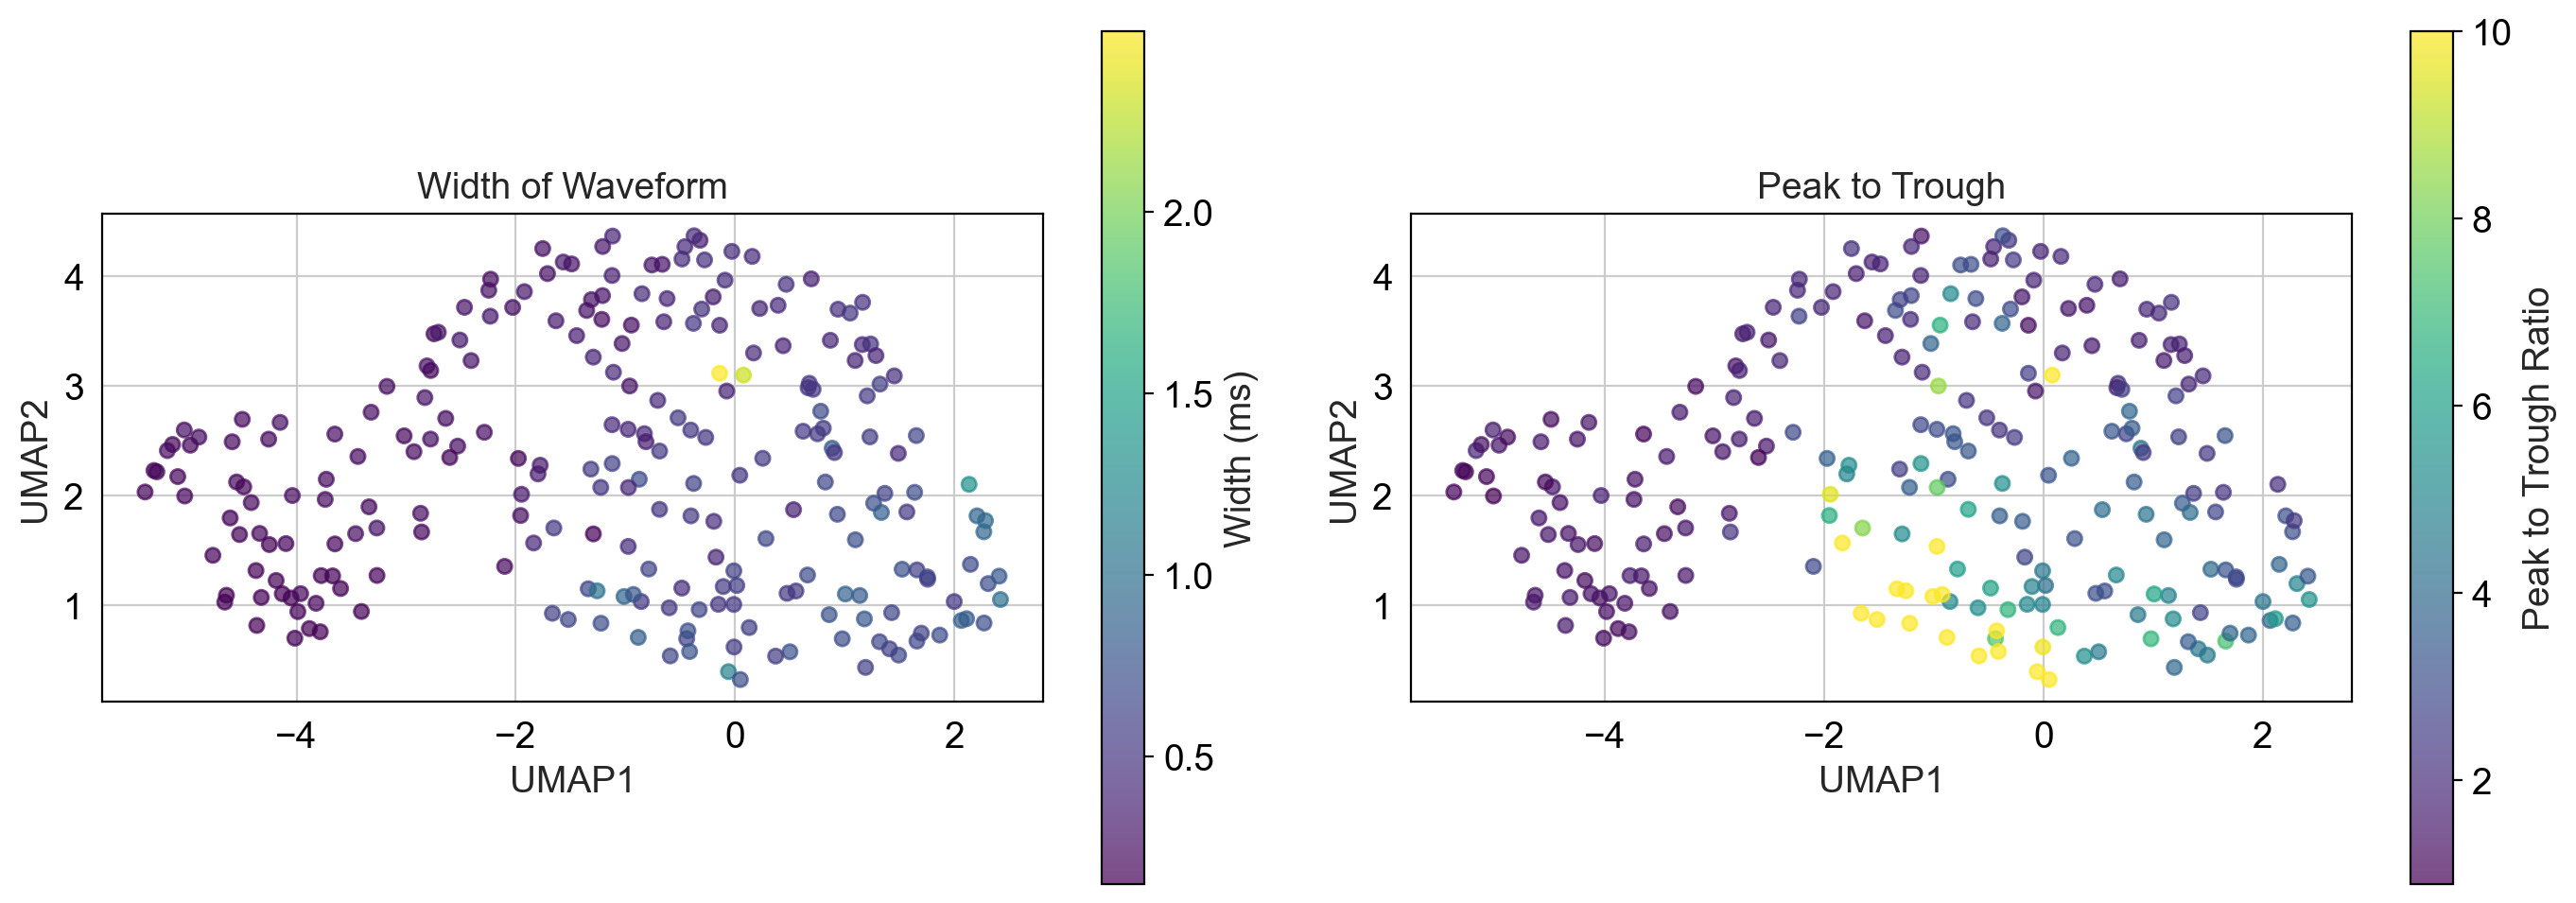

In [474]:
# Feature plots: Width and Peak-to-Trough ratio
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Width plot
ax = axes[0]
# Convert width to milliseconds if needed
width_ms = umap_df['width'] * 1000 if umap_df['width'].max() < 1 else umap_df['width']
scatter = ax.scatter(umap_df['UMAP1'], umap_df['UMAP2'],
                     c=width_ms, cmap='viridis', s=30, alpha=0.7)
plt.colorbar(scatter, ax=ax, label='Width (ms)')
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('Width of Waveform')
ax.set_aspect('equal')

# Peak-to-trough ratio plot
ax = axes[1]
scatter = ax.scatter(umap_df['UMAP1'], umap_df['UMAP2'],
                     c=umap_df['ratio_p2t'], cmap='viridis', s=30, alpha=0.7)
plt.colorbar(scatter, ax=ax, label='Peak to Trough Ratio')
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('Peak to Trough')
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

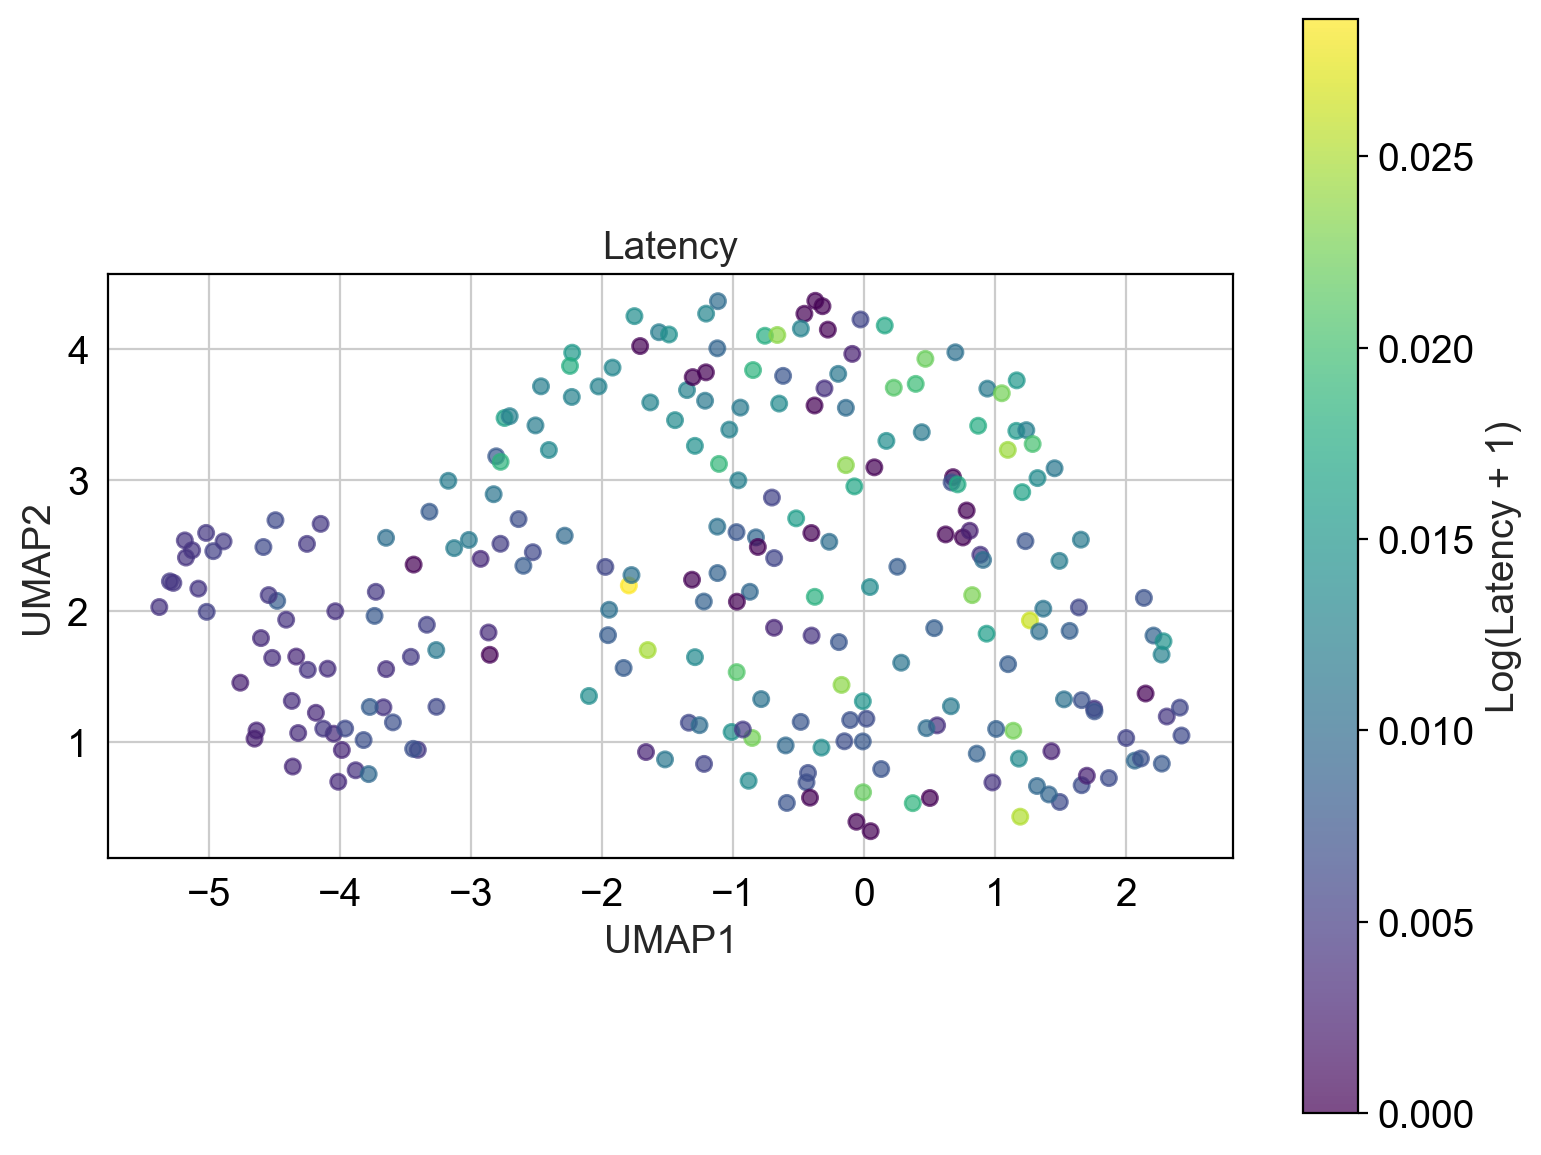

In [475]:
# Latency plot
fig, ax = plt.subplots(figsize=(8, 6))

# Use log scale for latency
log_latency = np.log1p(umap_df['latency'])
scatter = ax.scatter(umap_df['UMAP1'], umap_df['UMAP2'],
                     c=log_latency, cmap='viridis', s=30, alpha=0.7)
plt.colorbar(scatter, ax=ax, label='Log(Latency + 1)')
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('Latency')
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

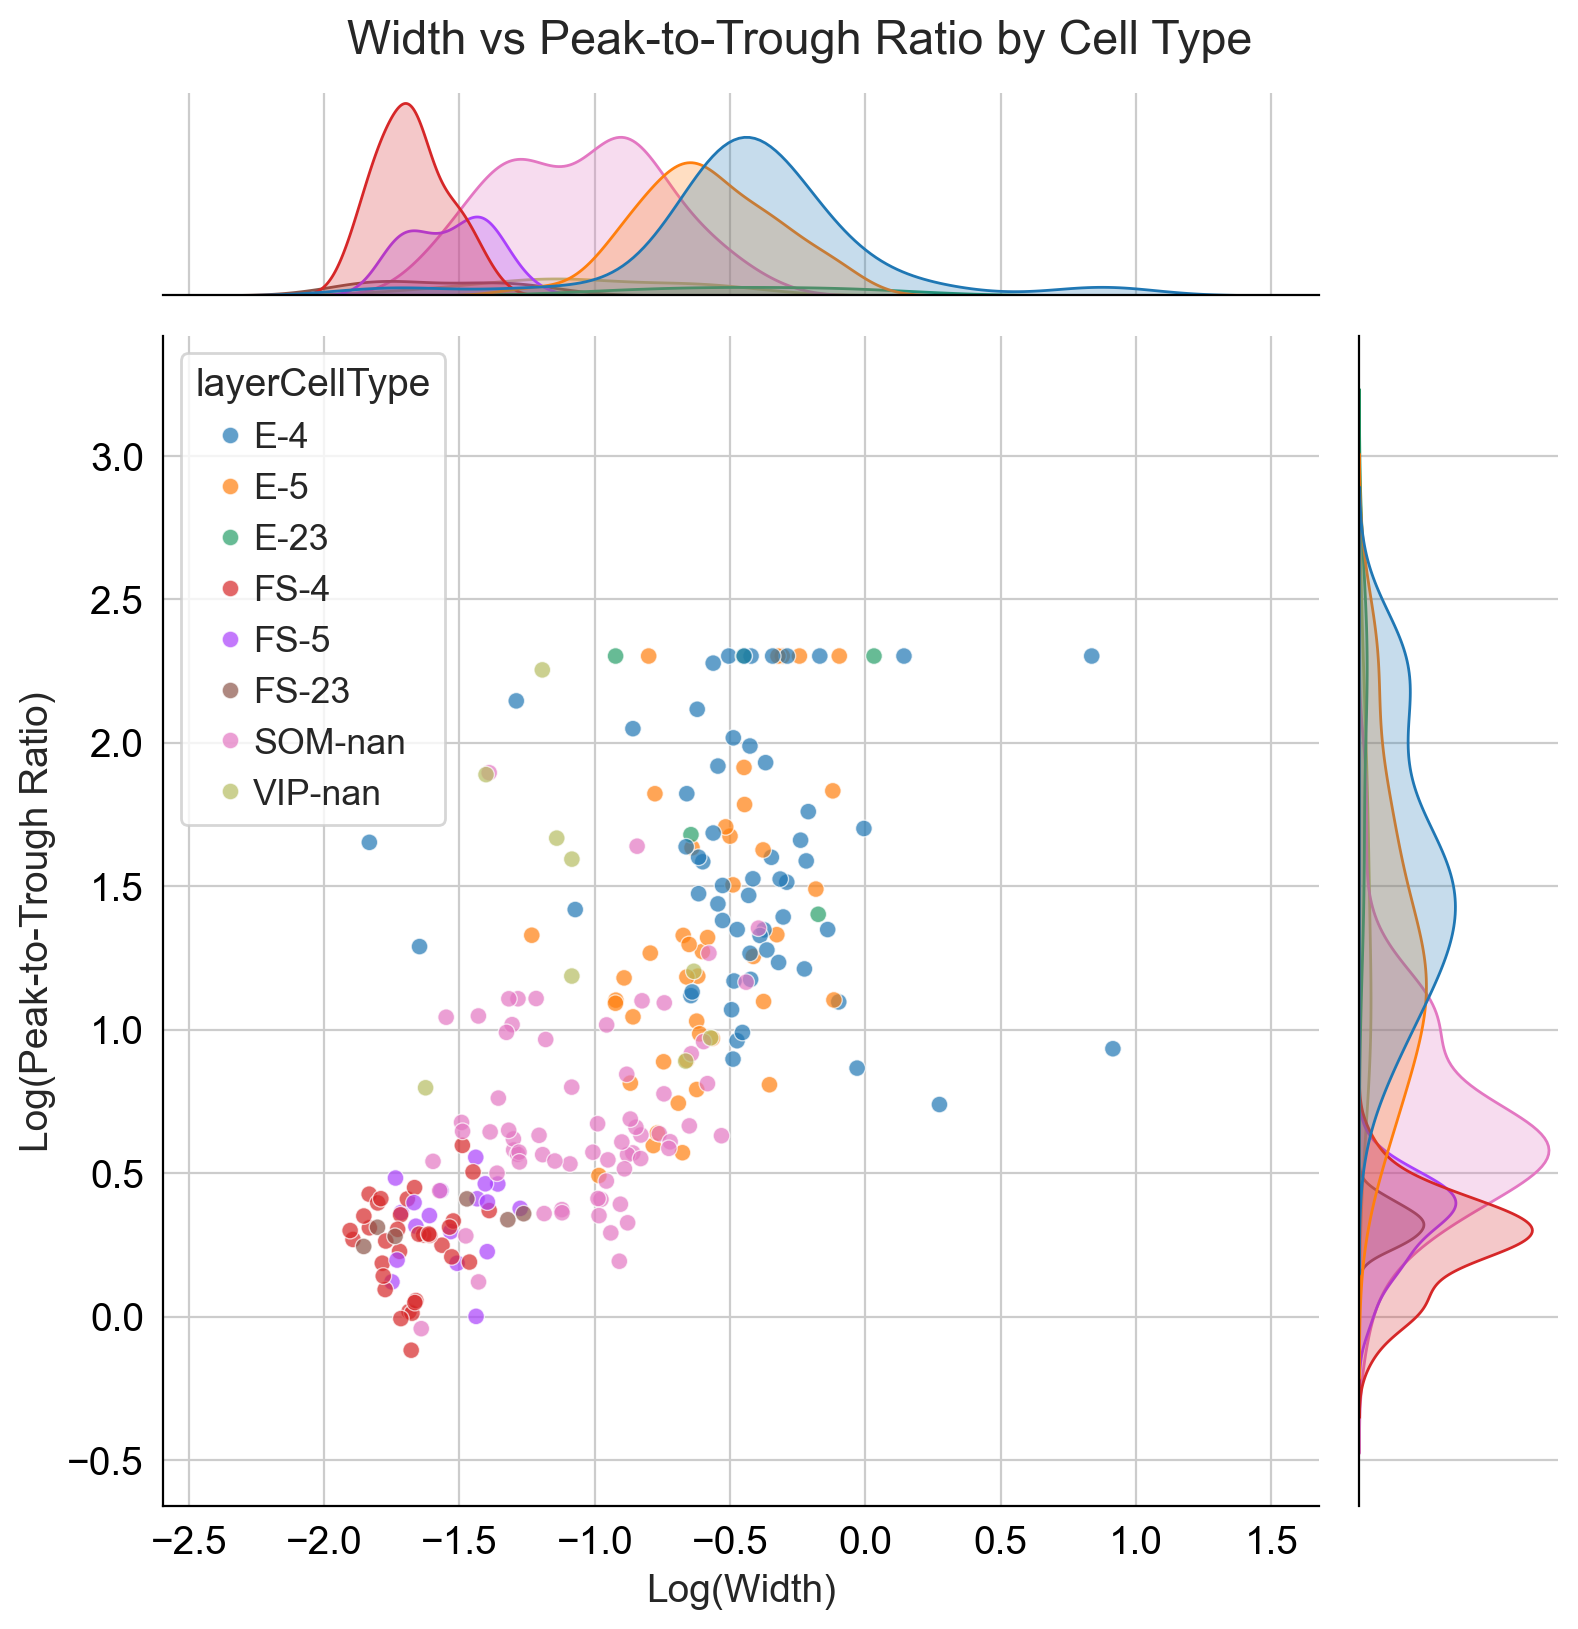

In [476]:
# Width vs Peak-to-Trough scatter plot with marginal histograms
# (equivalent to ggscatterhist in R)

# Prepare data with log transformations
plot_df = umap_df.copy()
plot_df['log_width'] = np.log(plot_df['width'] + 1e-6)
plot_df['log_ratio_p2t'] = np.log(plot_df['ratio_p2t'] + 1e-6)

# Create joint plot
g = sns.jointplot(
    data=plot_df,
    x='log_width',
    y='log_ratio_p2t',
    hue='layerCellType',
    kind='scatter',
    height=8,
    alpha=0.7
)
g.ax_joint.set_xlabel('Log(Width)')
g.ax_joint.set_ylabel('Log(Peak-to-Trough Ratio)')
plt.suptitle('Width vs Peak-to-Trough Ratio by Cell Type', y=1.02)
plt.show()

## 9. Modal Weight Visualization

Since we used equal weights for the simple concatenation approach, this section shows placeholder visualizations. For true WNN-style adaptive weights, consider implementing Seurat's WNN algorithm or using muon's multi-modal analysis tools.

In [477]:
# Use the modality weights computed by Muon's WNN
# Muon stores them as 'WF:mod_weight', 'ISI:mod_weight', 'PSTH:mod_weight'

print("Modality weights from Muon WNN:")
print(f"Available weight columns: {[col for col in mdata_wnn.obs.columns if 'weight' in col.lower()]}")

# Rename weights for easier access
weight_mapping = {
    'WF:mod_weight': 'WF_weight',
    'ISI:mod_weight': 'ISI_weight', 
    'PSTH:mod_weight': 'PSTH_weight'
}

for old_name, new_name in weight_mapping.items():
    if old_name in mdata_wnn.obs.columns:
        mdata_wnn.obs[new_name] = mdata_wnn.obs[old_name]
        mdata.obs[new_name] = mdata_wnn.obs[old_name].values
        print(f"{new_name} - mean: {mdata_wnn.obs[old_name].mean():.3f}, std: {mdata_wnn.obs[old_name].std():.3f}")

# Add weights to umap_df for plotting
for weight_col in ['WF_weight', 'ISI_weight', 'PSTH_weight']:
    if weight_col in mdata.obs.columns:
        umap_df[weight_col] = mdata.obs[weight_col].values

Modality weights from Muon WNN:
Available weight columns: ['WF:mod_weight', 'ISI:mod_weight', 'PSTH:mod_weight']
WF_weight - mean: 0.398, std: 0.091
ISI_weight - mean: 0.306, std: 0.078
PSTH_weight - mean: 0.296, std: 0.055


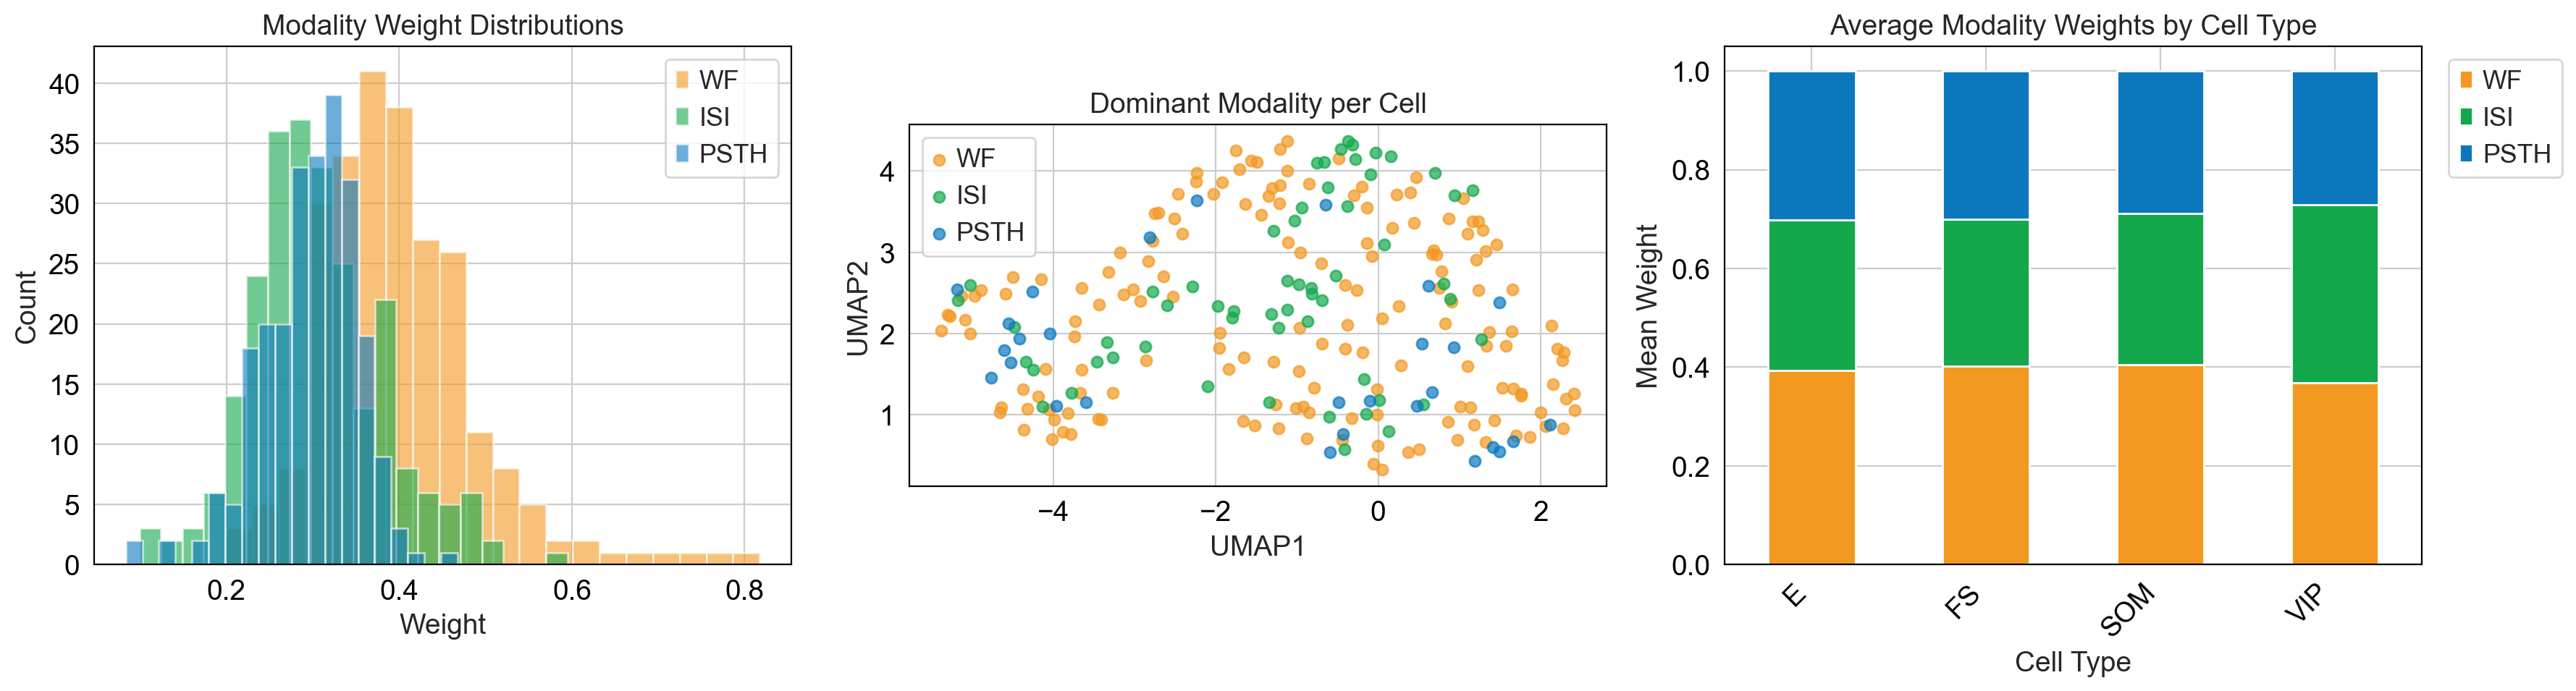

In [478]:
# Visualize modality weights

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Weight histograms (like p.hist in R)
ax = axes[0]
colors = {'WF_weight': '#F39922', 'ISI_weight': '#12A84B', 'PSTH_weight': '#0B78BE'}
labels = {'WF_weight': 'WF', 'ISI_weight': 'ISI', 'PSTH_weight': 'PSTH'}

for weight_col in ['WF_weight', 'ISI_weight', 'PSTH_weight']:
    if weight_col in umap_df.columns:
        ax.hist(umap_df[weight_col], bins=20, alpha=0.6, 
                color=colors[weight_col], label=labels[weight_col])

ax.set_xlabel('Weight')
ax.set_ylabel('Count')
ax.set_title('Modality Weight Distributions')
ax.legend()

# Plot 2: UMAP colored by dominant modality
ax = axes[1]
if all(col in umap_df.columns for col in ['WF_weight', 'ISI_weight', 'PSTH_weight']):
    # Determine dominant modality for each cell
    weight_cols = ['WF_weight', 'ISI_weight', 'PSTH_weight']
    dominant = umap_df[weight_cols].idxmax(axis=1)
    dominant_colors = dominant.map({'WF_weight': colors['WF_weight'], 
                                     'ISI_weight': colors['ISI_weight'], 
                                     'PSTH_weight': colors['PSTH_weight']})
    
    for mod, color in [('WF_weight', colors['WF_weight']), 
                        ('ISI_weight', colors['ISI_weight']), 
                        ('PSTH_weight', colors['PSTH_weight'])]:
        mask = dominant == mod
        ax.scatter(umap_df.loc[mask, 'UMAP1'], umap_df.loc[mask, 'UMAP2'],
                   c=color, label=labels[mod], s=30, alpha=0.7)
    
    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
    ax.set_title('Dominant Modality per Cell')
    ax.legend()
    ax.set_aspect('equal')

# Plot 3: Stacked bar showing weight composition by cell type
ax = axes[2]
if 'CellType' in umap_df.columns:
    weight_by_type = umap_df.groupby('CellType')[['WF_weight', 'ISI_weight', 'PSTH_weight']].mean()
    weight_by_type.plot(kind='bar', stacked=True, ax=ax, 
                        color=[colors['WF_weight'], colors['ISI_weight'], colors['PSTH_weight']])
    ax.set_xlabel('Cell Type')
    ax.set_ylabel('Mean Weight')
    ax.set_title('Average Modality Weights by Cell Type')
    ax.legend(['WF', 'ISI', 'PSTH'], bbox_to_anchor=(1.02, 1), loc='upper left')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

## 10. Classification Analysis

Compare classification accuracy between multimodal (WNN) and unimodal (WF, ISI, PSTH) representations for the five most prevalent cell types: E-4, E-5, FS-4, FS-5, SOM-nan.

This mirrors the analysis in `classifyData.r` using scikit-learn's GradientBoostingClassifier.

In [479]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score


def classify_embeddings(embeddings, labels, n_repeats=20, test_size=0.2):
    """
    Perform classification using GradientBoostingClassifier.
    
    Mirrors the R code in classifyData.r which uses:
    - method = "gbm" (Gradient Boosting Machine)
    - 80/20 train/test split
    - Multiple random seeds for robust evaluation
    
    Args:
        embeddings: numpy array of shape (n_samples, n_features)
        labels: numpy array of class labels
        n_repeats: number of times to repeat classification with different splits
        test_size: fraction of data to use for testing
        
    Returns:
        per_class_accuracies: dict mapping class -> list of balanced accuracies
        overall_accuracies: list of overall balanced accuracies (mean of per-class)
        classes: list of unique class names
    """
    classes = np.unique(labels)
    per_class_acc = {cls: [] for cls in classes}
    overall_acc = []
    
    for seed in range(1, n_repeats + 1):
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            embeddings, labels, test_size=test_size, 
            random_state=seed, stratify=labels
        )
        
        # Train GBM classifier
        clf = GradientBoostingClassifier(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=3,
            random_state=seed
        )
        clf.fit(X_train, y_train)
        
        # Predict
        y_pred = clf.predict(X_test)
        
        # Calculate per-class balanced accuracy
        run_per_class_acc = []
        for cls in classes:
            # For each class, calculate balanced accuracy treating it as binary
            cls_mask = (y_test == cls)
            if cls_mask.sum() > 0:
                # True positive rate (sensitivity) for this class
                tp_rate = ((y_pred == cls) & (y_test == cls)).sum() / (y_test == cls).sum()
                # True negative rate (specificity) for this class
                tn_rate = ((y_pred != cls) & (y_test != cls)).sum() / (y_test != cls).sum()
                balanced_acc = (tp_rate + tn_rate) / 2 * 100
                per_class_acc[cls].append(balanced_acc)
                run_per_class_acc.append(balanced_acc)
        
        # Overall balanced accuracy = mean of per-class balanced accuracies
        # This matches R's confusionMatrix approach
        overall_bal_acc = np.mean(run_per_class_acc)
        overall_acc.append(overall_bal_acc)
    
    return per_class_acc, overall_acc, classes

In [480]:
# Filter for the 5 prevalent cell types used in the R analysis
# These are: E-4, E-5, FS-4, FS-5, SOM-nan

target_cell_types = ['E-4', 'E-5', 'FS-4', 'FS-5', 'SOM-nan']

# Get layerCellType labels from modality metadata
layer_cell_types = mdata.mod['WF'].obs['layerCellType'].values

# Create boolean mask for cells matching target types
mask = np.isin(layer_cell_types, target_cell_types)

# Get filtered labels
filtered_labels = layer_cell_types[mask]

print(f"Total cells: {len(layer_cell_types)}")
print(f"Cells in target types: {mask.sum()}")
print(f"\nCell type distribution:")
for ct in target_cell_types:
    count = (filtered_labels == ct).sum()
    print(f"  {ct}: {count}")

Total cells: 246
Cells in target types: 225

Cell type distribution:
  E-4: 58
  E-5: 44
  FS-4: 35
  FS-5: 19
  SOM-nan: 69


In [481]:
# Compute higher-dimensional UMAP embeddings for classification
# This matches R's UMAP.components in constants.R
n_umap_dims = UMAP_COMPONENTS  # Currently 10

# Dynamic key name based on dimensions
umap_key = f'X_umap_{n_umap_dims}d'
wnn_umap_key = f'X_wnn_umap_{n_umap_dims}d'

print(f"Computing {n_umap_dims}D UMAP embeddings for classification...")
print(f"Storing in keys: '{umap_key}' and '{wnn_umap_key}'")

# WF
sc.tl.umap(adata_wf, n_components=n_umap_dims, random_state=UMAP_SEED, min_dist=UMAP_MIN_DIST)
adata_wf.obsm[umap_key] = adata_wf.obsm['X_umap'].copy()
print(f"  WF: {adata_wf.obsm[umap_key].shape}")

# ISI
sc.tl.umap(adata_isi, n_components=n_umap_dims, random_state=UMAP_SEED, min_dist=UMAP_MIN_DIST)
adata_isi.obsm[umap_key] = adata_isi.obsm['X_umap'].copy()
print(f"  ISI: {adata_isi.obsm[umap_key].shape}")

# PSTH
sc.tl.umap(adata_psth, n_components=n_umap_dims, random_state=UMAP_SEED, min_dist=UMAP_MIN_DIST)
adata_psth.obsm[umap_key] = adata_psth.obsm['X_umap'].copy()
print(f"  PSTH: {adata_psth.obsm[umap_key].shape}")

# WNN - on the combined neighbor graph
mu.tl.umap(mdata_wnn, neighbors_key='wnn', n_components=n_umap_dims, 
           random_state=UMAP_SEED, min_dist=UMAP_MIN_DIST)
mdata.obsm[wnn_umap_key] = mdata_wnn.obsm['X_umap'].copy()
print(f"  WNN: {mdata.obsm[wnn_umap_key].shape}")

print("\nUMAP embeddings computed!")

Computing 10D UMAP embeddings for classification...
Storing in keys: 'X_umap_10d' and 'X_wnn_umap_10d'
  WF: (246, 10)
  ISI: (246, 10)
  PSTH: (246, 10)
  WNN: (246, 10)

UMAP embeddings computed!


In [482]:
# Run classification on each modality's UMAP embeddings
n_repeats = 20

# Prepare UMAP embeddings for each modality (using dynamic keys from previous cell)
embeddings_dict = {
    'WNN': mdata.obsm[wnn_umap_key][mask],
    'WF': adata_wf.obsm[umap_key][mask],
    'ISI': adata_isi.obsm[umap_key][mask],
    'PSTH': adata_psth.obsm[umap_key][mask],
}

# Add features (width, ratio_p2t) if available
if 'width' in mod_obs.columns and 'ratio_p2t' in mod_obs.columns:
    width_vals = mod_obs['width'].values[mask]
    ratio_vals = mod_obs['ratio_p2t'].values[mask]
    # Replace NaN with 0
    width_vals = np.nan_to_num(width_vals, nan=0.0)
    ratio_vals = np.nan_to_num(ratio_vals, nan=0.0)
    embeddings_dict['Features'] = np.column_stack([width_vals, ratio_vals])

print(f"Using {n_umap_dims}D UMAP embeddings for classification")
print(f"Embedding dimensions:")
for name, emb in embeddings_dict.items():
    print(f"  {name}: {emb.shape}")

# Run classification for each modality
results = {}
print("\nRunning classification analysis (this may take a few minutes)...\n")

for mod_name, embeddings in embeddings_dict.items():
    print(f"Classifying {mod_name}...", end=" ")
    per_class_acc, overall_acc, classes = classify_embeddings(
        embeddings, filtered_labels, n_repeats=n_repeats
    )
    results[mod_name] = {
        'per_class': per_class_acc,
        'overall': overall_acc,
        'classes': classes
    }
    print(f"Mean accuracy: {np.mean(overall_acc):.1f}% ± {np.std(overall_acc):.1f}%")

print("\nClassification complete!")

Using 10D UMAP embeddings for classification
Embedding dimensions:
  WNN: (225, 10)
  WF: (225, 10)
  ISI: (225, 10)
  PSTH: (225, 10)
  Features: (225, 2)

Running classification analysis (this may take a few minutes)...

Classifying WNN... Mean accuracy: 83.5% ± 4.2%
Classifying WF... Mean accuracy: 79.4% ± 2.9%
Classifying ISI... Mean accuracy: 64.4% ± 4.2%
Classifying PSTH... Mean accuracy: 61.6% ± 3.3%
Classifying Features... Mean accuracy: 70.5% ± 6.0%

Classification complete!


In [483]:
# Create summary DataFrame for plotting
summary_data = []

for mod_name, res in results.items():
    for cls in res['classes']:
        acc_values = res['per_class'][cls]
        summary_data.append({
            'Modality': mod_name,
            'CellType': cls,
            'Accuracy': np.mean(acc_values),
            'Std': np.std(acc_values),
            'SE': np.std(acc_values) / np.sqrt(len(acc_values))
        })

summary_df = pd.DataFrame(summary_data)

# Also create raw data for statistical tests
raw_data = []
for mod_name, res in results.items():
    for cls in res['classes']:
        for run_idx, acc in enumerate(res['per_class'][cls]):
            raw_data.append({
                'Run': run_idx + 1,
                'Modality': mod_name,
                'CellType': cls,
                'Accuracy': acc
            })

raw_df = pd.DataFrame(raw_data)

print("Summary statistics:")
print(summary_df.pivot_table(index='CellType', columns='Modality', values='Accuracy').round(1))

Summary statistics:
Modality  Features   ISI  PSTH    WF   WNN
CellType                                  
E-4           78.7  61.5  61.0  84.8  85.0
E-5           57.4  51.2  57.1  76.1  77.2
FS-4          80.5  80.2  67.7  90.2  89.8
FS-5          57.1  62.5  55.0  61.1  76.7
SOM-nan       78.5  66.3  67.2  84.9  89.0


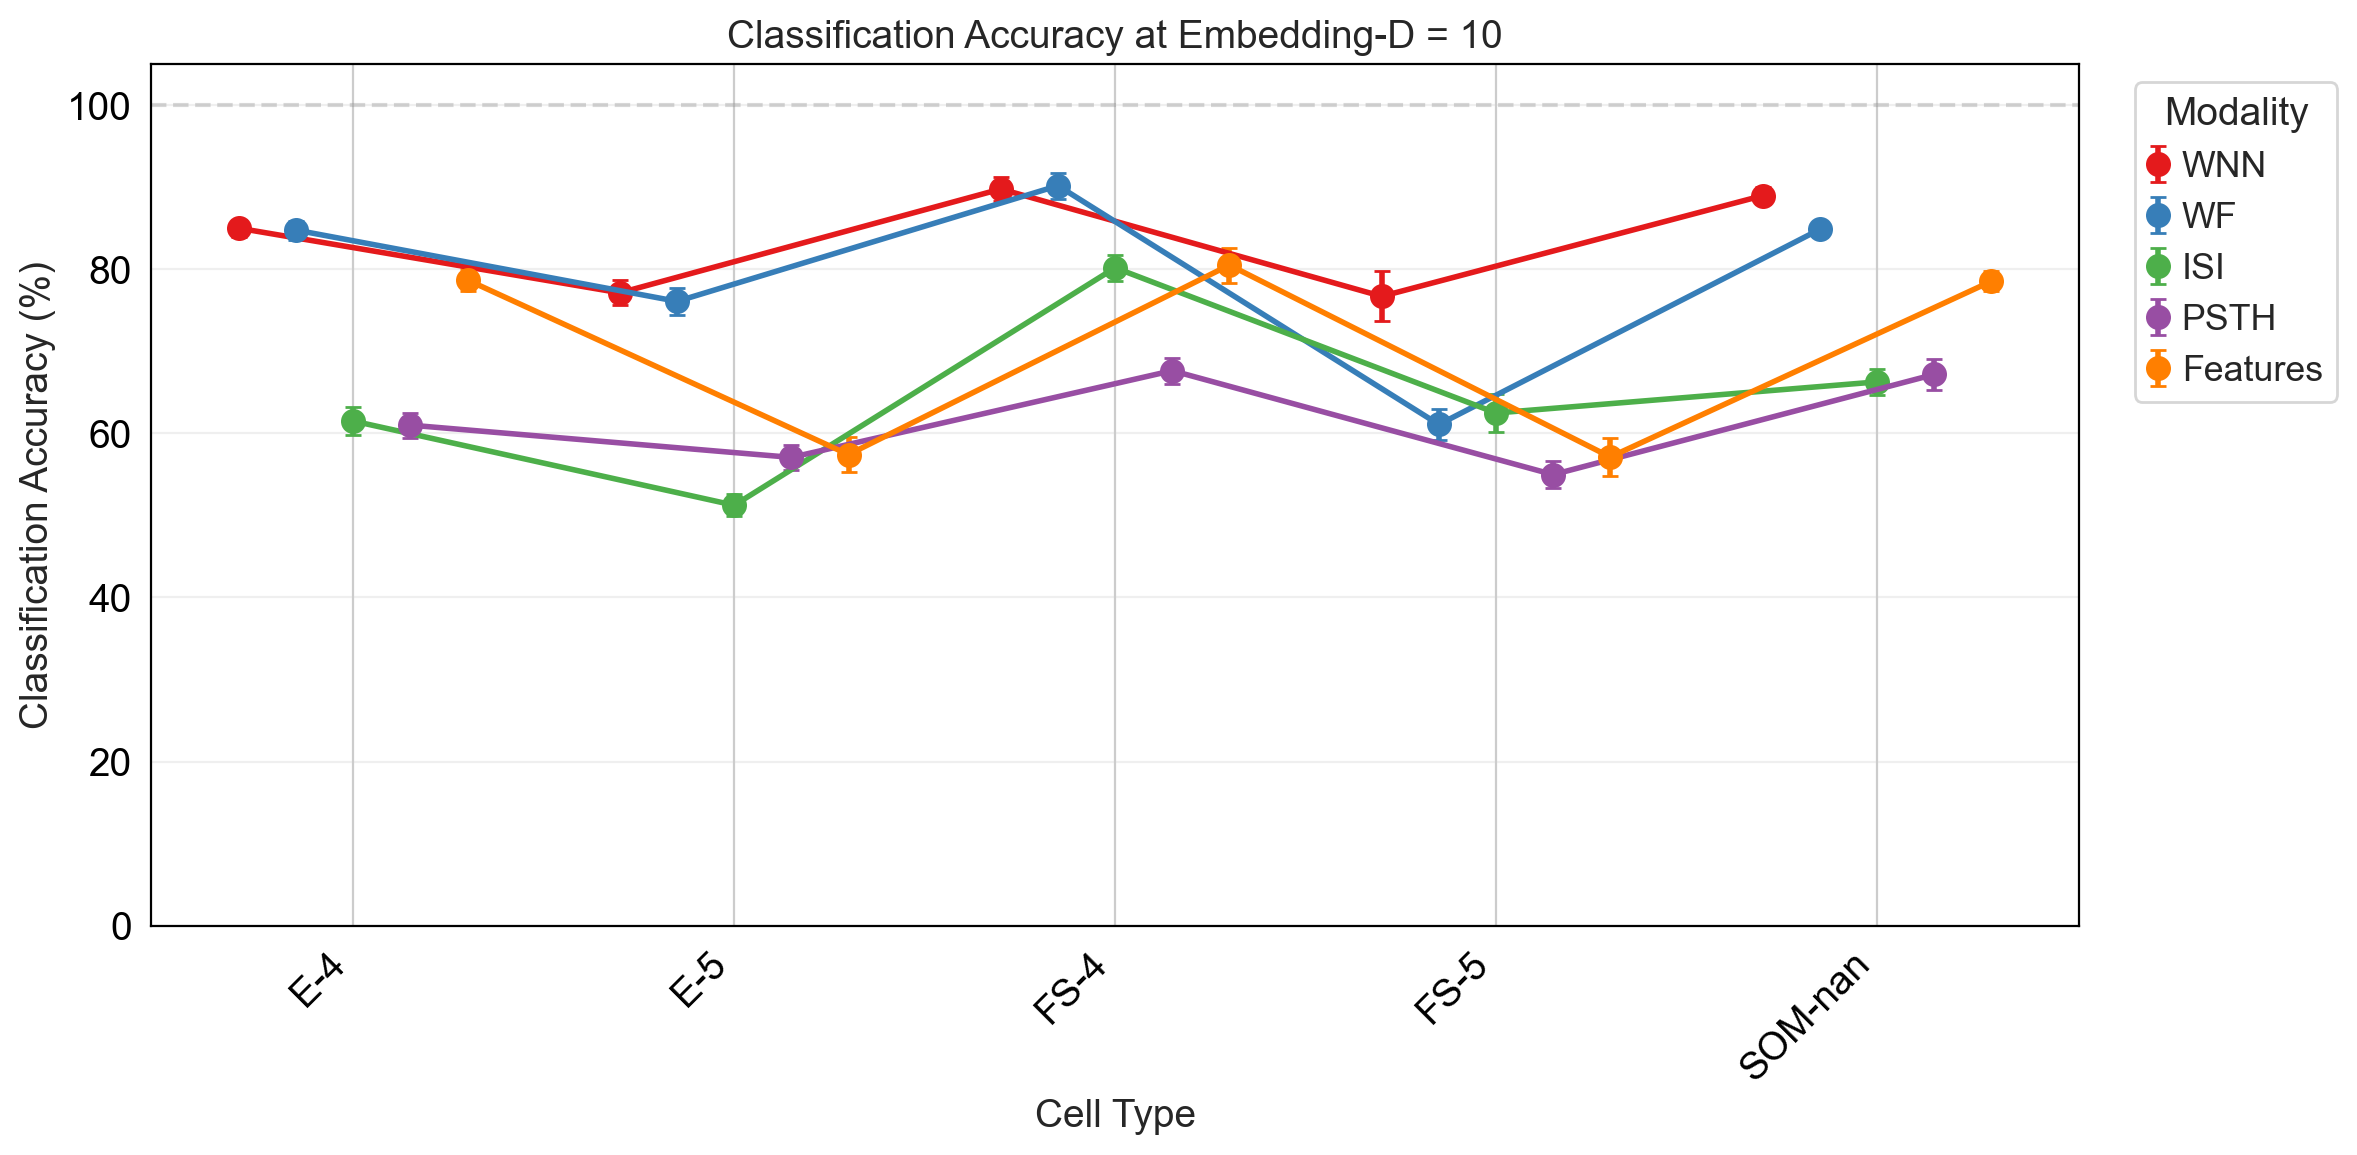

In [484]:
# Plot classification accuracy by cell type and modality
# Similar to the R plot in classifyData.r

fig, ax = plt.subplots(figsize=(12, 6))

# Define colors and markers for each modality
modality_colors = {
    'WNN': '#E41A1C',      # Red
    'WF': '#377EB8',       # Blue
    'ISI': '#4DAF4A',      # Green
    'PSTH': '#984EA3',     # Purple
    'Features': '#FF7F00'  # Orange
}

modality_order = ['WNN', 'WF', 'ISI', 'PSTH', 'Features']
cell_types = sorted(summary_df['CellType'].unique())

# Plot with dodge (offset) for each modality
width = 0.15
x = np.arange(len(cell_types))

for i, mod in enumerate(modality_order):
    if mod not in results:
        continue
    mod_data = summary_df[summary_df['Modality'] == mod].set_index('CellType')
    
    # Reorder to match cell_types
    means = [mod_data.loc[ct, 'Accuracy'] if ct in mod_data.index else 0 for ct in cell_types]
    sems = [mod_data.loc[ct, 'SE'] if ct in mod_data.index else 0 for ct in cell_types]
    
    offset = (i - len(modality_order)/2 + 0.5) * width
    ax.errorbar(x + offset, means, yerr=sems, 
                fmt='o-', color=modality_colors[mod], 
                label=mod, capsize=3, markersize=8, linewidth=2)

ax.set_xticks(x)
ax.set_xticklabels(cell_types, rotation=45, ha='right')
ax.set_xlabel('Cell Type')
ax.set_ylabel('Classification Accuracy (%)')
ax.set_title(f'Classification Accuracy at Embedding-D = {n_umap_dims}')
ax.legend(title='Modality', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.set_ylim(0, 105)
ax.axhline(y=100, color='gray', linestyle='--', alpha=0.3)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

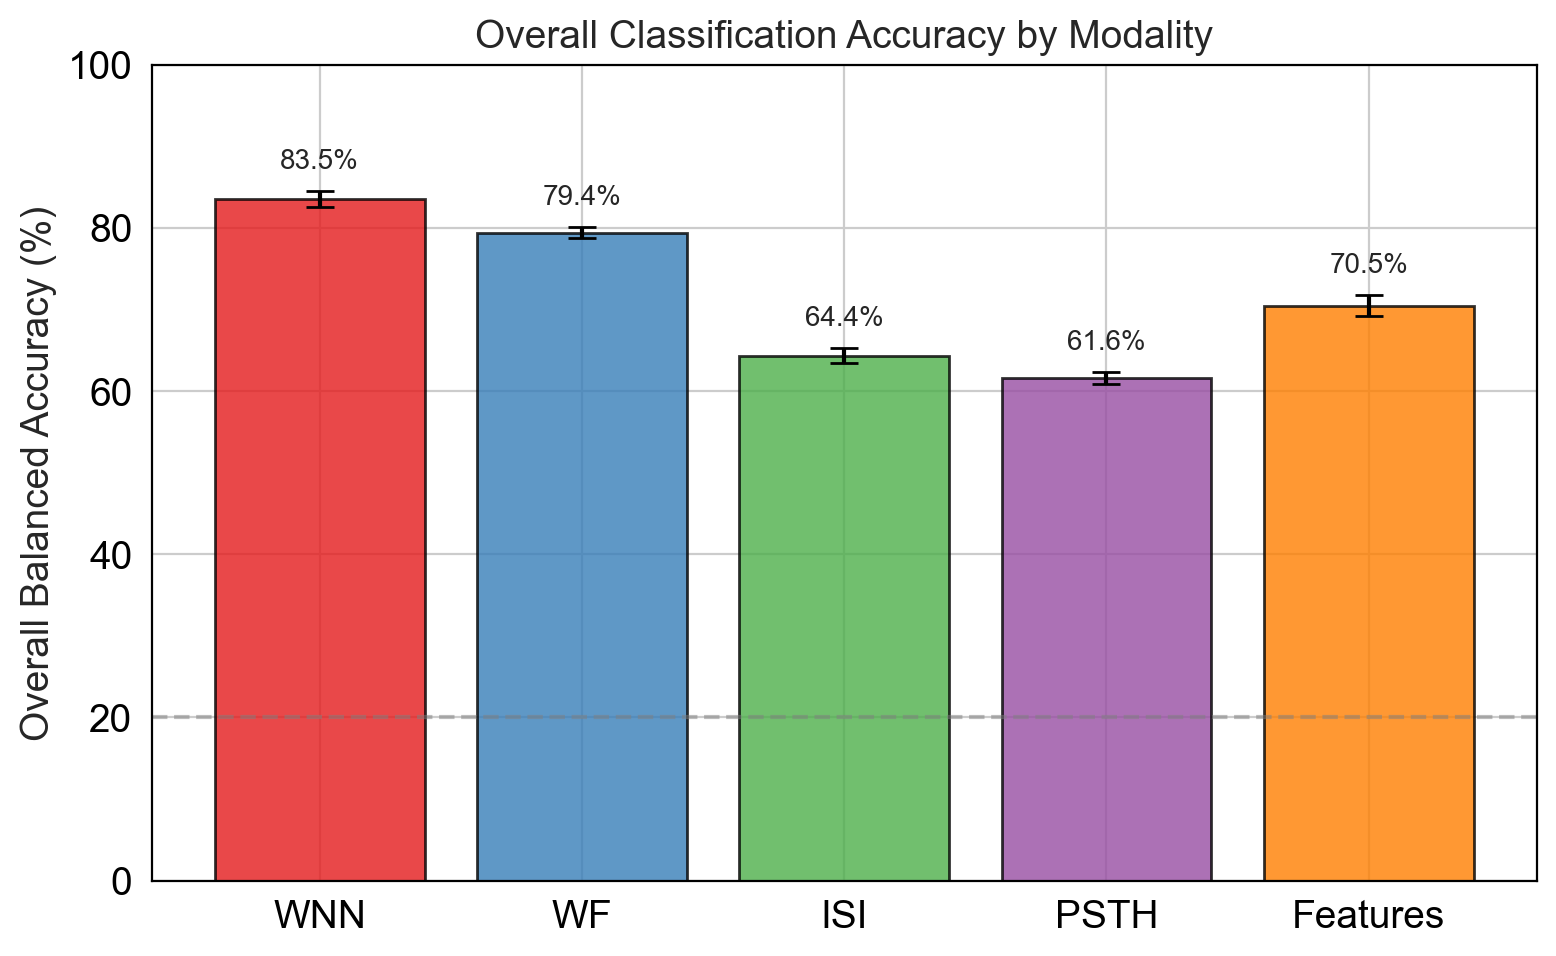


Overall Accuracy Summary:
----------------------------------------
WNN       :  83.5% ±  4.2%
WF        :  79.4% ±  2.9%
ISI       :  64.4% ±  4.2%
PSTH      :  61.6% ±  3.3%
Features  :  70.5% ±  6.0%


In [485]:
# Overall accuracy comparison (barplot with error bars)
fig, ax = plt.subplots(figsize=(8, 5))

modalities = []
means = []
sems = []

for mod in modality_order:
    if mod in results:
        modalities.append(mod)
        means.append(np.mean(results[mod]['overall']))
        sems.append(np.std(results[mod]['overall']) / np.sqrt(len(results[mod]['overall'])))

x = np.arange(len(modalities))
colors = [modality_colors[m] for m in modalities]

bars = ax.bar(x, means, yerr=sems, capsize=5, color=colors, alpha=0.8, edgecolor='black')

ax.set_xticks(x)
ax.set_xticklabels(modalities)
ax.set_ylabel('Overall Balanced Accuracy (%)')
ax.set_title('Overall Classification Accuracy by Modality')
ax.set_ylim(0, 100)
ax.axhline(y=20, color='gray', linestyle='--', alpha=0.5, label='Chance level (5 classes)')

# Add value labels on bars
for bar, mean, sem in zip(bars, means, sems):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + sem + 2,
            f'{mean:.1f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Print summary
print("\nOverall Accuracy Summary:")
print("-" * 40)
for mod in modality_order:
    if mod in results:
        acc = results[mod]['overall']
        print(f"{mod:10s}: {np.mean(acc):5.1f}% ± {np.std(acc):4.1f}%")

# Print summary
print("=" * 50)
print("Analysis Summary")
print("=" * 50)
print(f"\nTotal cells: {mdata.n_obs}")
print(f"\nModalities processed:")
print(f"  - ISI: {mdata.mod['ISI'].n_vars} features")
print(f"  - WF: {mdata.mod['WF'].n_vars} features")
print(f"  - PSTH: {mdata.mod['PSTH'].n_vars} features")
print(f"\nWNN UMAP dimensions: {mdata.obsm['X_wnn_umap'].shape}")
print(f"\nClusters found: {mdata.obs['wnn_leiden'].nunique()}")

# Get metadata from modality
mod_obs = mdata.mod['WF'].obs
print(f"\nCell types:")
print(mod_obs['CellType'].value_counts())
print(f"\nLayer distribution:")
print(mod_obs['Layer'].value_counts())

# Print weight summary if available
if 'WF_weight' in mdata.obs.columns:
    print(f"\nModality weight summary:")
    for mod in ['WF', 'ISI', 'PSTH']:
        col = f'{mod}_weight'
        if col in mdata.obs.columns:
            print(f"  - {mod}: mean={mdata.obs[col].mean():.3f}, std={mdata.obs[col].std():.3f}")

In [486]:
# Print summary
print("=" * 50)
print("Analysis Summary")
print("=" * 50)
print(f"\nTotal cells: {mdata.n_obs}")
print(f"\nModalities processed:")
print(f"  - ISI: {mdata.mod['ISI'].n_vars} features")
print(f"  - WF: {mdata.mod['WF'].n_vars} features")
print(f"  - PSTH: {mdata.mod['PSTH'].n_vars} features")
# print(f"\nJoint embedding dimensions: {mdata.obsm['X_joint_pca'].shape[1]}")
print(f"\nClusters found: {mdata.obs['wnn_leiden'].nunique()}")
# print(f"\nCell types:")
# print(mdata.obs['CellType'].value_counts())
# print(f"\nLayer distribution:")
# print(mdata.obs['Layer'].value_counts())

Analysis Summary

Total cells: 246

Modalities processed:
  - ISI: 100 features
  - WF: 351 features
  - PSTH: 151 features

Clusters found: 10


In [487]:
# Save processed data
# mdata.write('processed_jianing.h5mu')
# print("Saved processed data to processed_jianing.h5mu")